In [1]:
import random as rd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error #, r2_score
from sklearn.model_selection import train_test_split

import gspread
from sqlalchemy import create_engine
import re

gc = gspread.service_account(filename="./credentials.json")

import environ
env = environ.Env()
database_url = env.str(
    var="DATABASE_URL", default="postgres://postgres:@postgres:5432/postgres"
)
engine = create_engine(database_url, echo=False)

ModuleNotFoundError: No module named 'sklearn'

In [2]:
time = pd.read_sql("etl_sale_deals_time_of_stage", engine)

In [3]:
time.head()

,deal_id,pipeline_id,status,lead_to_meeting,meeting_to_Final
0,11,1,lost,963200,963200
1,25,1,won,341107,4403095
2,28,1,lost,0,6644327
3,29,1,won,0,2148487
4,30,5,won,2148100,2148100


In [4]:
# time = time[time['status'] == 'won']

In [5]:
time.dtypes

deal_id              int64
pipeline_id          int64
status              object
lead_to_meeting      int64
meeting_to_Final     int64
dtype: object

In [6]:
time = time[(time['meeting_to_Final'] > 10000) & (time['meeting_to_Final'] <= 10000000)]

In [7]:
time

,deal_id,pipeline_id,status,lead_to_meeting,meeting_to_Final
0,11,1,lost,963200,963200
1,25,1,won,341107,4403095
2,28,1,lost,0,6644327
3,29,1,won,0,2148487
4,30,5,won,2148100,2148100
...,...,...,...,...,...
111,393,10,lost,2246711,2246711
112,404,10,lost,1461060,1461060
113,409,10,lost,1830169,1830169
114,443,10,lost,516662,516662


In [8]:
deals = pd.read_sql("etl_sale_deals", engine)

In [9]:
deals.head()

,deal_id,creator_user_id,user_id,person_id,org_id,stage_id,title,value,currency,add_time,...,weighted_value,formatted_weighted_value,weighted_value_currency,rotten_time,owner_name,cc_email,org_hidden,person_hidden,product_id,product_name
0,10,"{""id"": 11611129, ""name"": ""Sales Tracking"", ""em...","{""id"": 11611129, ""name"": ""Sales Tracking"", ""em...","{""active_flag"": true, ""name"": ""\u0e22\u0e07\u0...","{""name"": ""\u0e1a\u0e23\u0e34\u0e29\u0e31\u0e17...",62,บริษัท วี.เค.จี กรุ๊ป จำกัด,0,THB,2020-07-13 03:35:33,...,0,THB 0,THB,None,Sales Tracking,codium2+deal10@pipedrivemail.com,False,False,NaN,None
1,11,"{""id"": 11611129, ""name"": ""Sales Tracking"", ""em...","{""id"": 11611129, ""name"": ""Sales Tracking"", ""em...","{""active_flag"": true, ""name"": ""\u0e17\u0e27\u0...",null,2,ทวี สกุลคุณสวัสดิ์,0,THB,2020-07-13 03:42:29,...,0,THB 0,THB,None,Sales Tracking,codium2+deal11@pipedrivemail.com,False,False,NaN,None
2,12,"{""id"": 11611129, ""name"": ""Sales Tracking"", ""em...","{""id"": 11611129, ""name"": ""Sales Tracking"", ""em...","{""active_flag"": true, ""name"": ""\u0e17\u0e34\u0...","{""name"": ""\u0e01\u0e23\u0e21\u0e22\u0e38\u0e17...",62,กรมยุทธศึกษาทหารบก,0,THB,2020-07-13 03:45:53,...,0,THB 0,THB,None,Sales Tracking,codium2+deal12@pipedrivemail.com,False,False,NaN,None
3,13,"{""id"": 11611129, ""name"": ""Sales Tracking"", ""em...","{""id"": 11611129, ""name"": ""Sales Tracking"", ""em...","{""active_flag"": true, ""name"": ""\u0e2a\u0e38\u0...","{""name"": ""\u0e1a\u0e23\u0e34\u0e29\u0e31\u0e17...",62,บริษัท อาบาคัสซึ,0,THB,2020-07-13 03:53:13,...,0,THB 0,THB,None,Sales Tracking,codium2+deal13@pipedrivemail.com,False,False,NaN,None
4,14,"{""id"": 11611129, ""name"": ""Sales Tracking"", ""em...","{""id"": 11611129, ""name"": ""Sales Tracking"", ""em...","{""active_flag"": true, ""name"": ""Warathep Chalad...","{""name"": ""SNC FORMER PUBLIC COMPANY LIMITED."",...",62,SNC FORMER PUBLIC COMPANY LIMITED.,0,THB,2020-07-13 04:07:23,...,0,THB 0,THB,None,Sales Tracking,codium2+deal14@pipedrivemail.com,False,False,NaN,None


In [10]:
deals.isnull().sum()

deal_id              0
creator_user_id      0
user_id              0
person_id            0
org_id               0
                  ... 
cc_email             0
org_hidden           0
person_hidden        0
product_id         420
product_name       420
Length: 64, dtype: int64

In [11]:
# deals.columns.to_list()

In [12]:
deals_time = deals[['deal_id', 'add_time', 'value', 'lost_reason']]

In [13]:
deal_merge = time.merge(deals_time, on='deal_id', how='inner')
# deal_merge = deal_merge[deal_merge['add_time'] > '2020-10-1']
deal_merge['Date'] = pd.to_datetime(deal_merge['add_time'])
deal_merge.dtypes
deal_merge['week'] = deal_merge['Date'].dt.isocalendar().week
deal_merge.drop(columns=['Date'], inplace=True)

In [14]:
deal_merge

,deal_id,pipeline_id,status,lead_to_meeting,meeting_to_Final,add_time,value,lost_reason,week
0,11,1,lost,963200,963200,2020-07-13 03:42:29,0,ติดต่อลูกค้าไม่ได้,29
1,25,1,won,341107,4403095,2020-07-13 04:52:56,73600,None,29
2,25,1,won,341107,4403095,2020-07-13 04:52:56,73600,None,29
3,28,1,lost,0,6644327,2020-07-13 06:17:48,0,ทางผู้บริหารบอกว่าราคาสูงเกินไป,29
4,29,1,won,0,2148487,2020-07-13 06:21:17,284000,None,29
...,...,...,...,...,...,...,...,...,...
98,393,10,lost,2246711,2246711,2021-02-10 07:54:24,0,client want ERP,6
99,404,10,lost,1461060,1461060,2021-02-15 06:14:44,0,cannot contact client,7
100,409,10,lost,1830169,1830169,2021-02-16 03:19:31,0,they want a production management system,7
101,443,10,lost,516662,516662,2021-02-24 03:26:50,0,we don't sell e-withholding tax,8


In [15]:
from sklearn.preprocessing import LabelEncoder

def labelEncode(data, columns):
    for i in columns:
#         print(i)
        lb = LabelEncoder().fit_transform(data[i])
        data[i + '_'] = lb
columns = ['status']
labelEncode(deal_merge, columns)

for i, row in deal_merge.iterrows():
    if row['lost_reason'] is None:
             
    else:
        deal_merge['lost_reason'].iloc[int(i)] = 0
        

/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [16]:
deal_merge.set_index('add_time', inplace=True)

In [17]:
deal_merge

,deal_id,pipeline_id,status,lead_to_meeting,meeting_to_Final,value,lost_reason,week,status_
add_time,,,,,,,,,
2020-07-13 03:42:29,11,1,lost,963200,963200,0,0,29,0
2020-07-13 04:52:56,25,1,won,341107,4403095,73600,1,29,1
2020-07-13 04:52:56,25,1,won,341107,4403095,73600,1,29,1
2020-07-13 06:17:48,28,1,lost,0,6644327,0,0,29,0
2020-07-13 06:21:17,29,1,won,0,2148487,284000,1,29,1
...,...,...,...,...,...,...,...,...,...
2021-02-10 07:54:24,393,10,lost,2246711,2246711,0,0,6,0
2021-02-15 06:14:44,404,10,lost,1461060,1461060,0,0,7,0
2021-02-16 03:19:31,409,10,lost,1830169,1830169,0,0,7,0


In [18]:
# deal_merge['meeting_to_Final'] = deal_merge['meeting_to_Final'].astype(float)
deal_merge.meeting_to_Final = deal_merge.meeting_to_Final.div(3600)

In [19]:
# deal_merge.meeting_to_Final

<AxesSubplot:xlabel='add_time'>

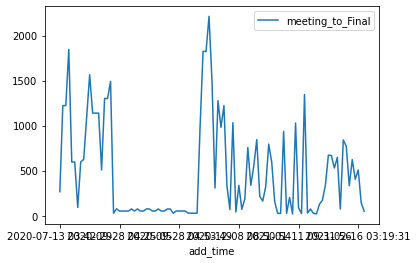

In [20]:
cols_plot = ['meeting_to_Final']
deal_merge[cols_plot].plot()

array([<AxesSubplot:xlabel='add_time'>, <AxesSubplot:xlabel='add_time'>,
       <AxesSubplot:xlabel='add_time'>, <AxesSubplot:xlabel='add_time'>,
       <AxesSubplot:xlabel='add_time'>, <AxesSubplot:xlabel='add_time'>,
       <AxesSubplot:xlabel='add_time'>, <AxesSubplot:xlabel='add_time'>],
      dtype=object)

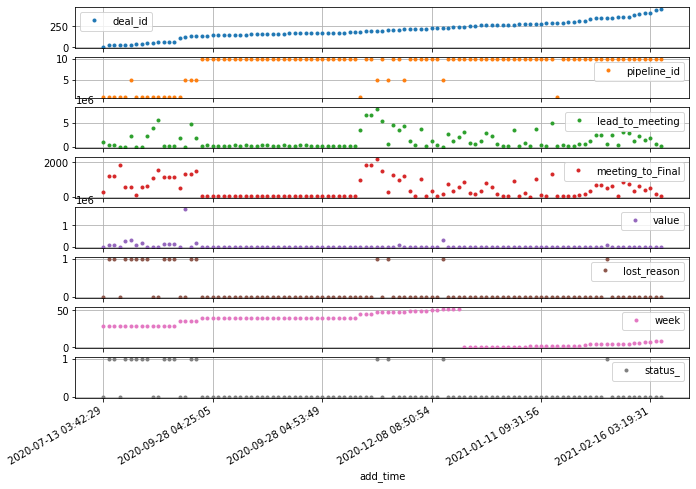

In [21]:
deal_merge.plot(marker='.', linestyle='None', figsize=(11,8), subplots=True, grid=True)

In [22]:
# g = sns.pairplot(deal_merge)
# g.fig.set_size_inches(9, 9)

In [23]:
from scipy.stats import zscore

# deal_merge['zscore_time'] = zscore(deal_merge.meeting_to_Final, ddof=0)

In [24]:
# deal_merge

<AxesSubplot:>

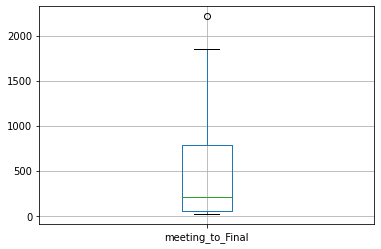

In [25]:
deal_merge.boxplot('meeting_to_Final')

In [26]:

q3 = deal_merge.meeting_to_Final.quantile(.75)
q1 = deal_merge.meeting_to_Final.quantile(.25)

# q1, q3= np.percentile(df.Buy, [25,75])

iqr = q3 - q1

print('Q1: {}' . format(q1))
print('Q3: {}' . format(q3))
print('IQR: {}' . format(iqr))

upper = q3 + (1.5 * iqr)
lower = q1 - (1.5 * iqr)
print('Lower: {:.2f} \nUpper: {:.2f}' . format(lower, upper))

Q1: 53.31944444444444
Q3: 782.6105555555556
IQR: 729.2911111111111
Lower: -1040.62 
Upper: 1876.55


/usr/local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


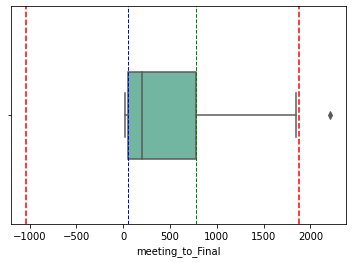

In [27]:
plt.axvline(x=q1, c='b', linestyle='--', linewidth=1)
plt.axvline(x=q3, c='g', linestyle='--', linewidth=1)
plt.axvline(x=lower, c='r', linestyle='--')
plt.axvline(x=upper, c='r', linestyle='--')
sns.boxplot(deal_merge.meeting_to_Final, width=0.4, palette='Set2')
plt.show()

In [28]:
lead = pd.read_sql("lead_progress", engine)

In [29]:
lead

,week,status,Cost,clicks,impressions
0,42,1,1950.53,158.0,49977.0
1,44,2,1131.68,475.0,44948.0
2,45,7,1380.95,336.0,7352.0
3,46,1,1501.54,370.0,10511.0
4,47,4,1585.33,420.0,14264.0
5,48,4,1693.97,1637.0,41693.0
6,49,2,3969.13,2897.0,62609.0
7,49,6,3969.13,2897.0,62609.0
8,50,2,2468.21,1638.0,53512.0
9,51,5,2218.27,466.0,15709.0


In [30]:
lead_count = lead[['week', 'status']]

In [31]:
lead_count.rename(columns={'status': 'lead'}, inplace=True)

/usr/local/lib/python3.8/site-packages/pandas/core/frame.py:4300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [32]:
winrate = deal_merge.merge(lead_count, on='week', how='left')

In [33]:
winrate.meeting_to_Final = winrate.meeting_to_Final.div(24).astype(int)
winrate.value = winrate.value.div(1000).astype(int)

In [34]:
winrate['lead'] = winrate['lead'].fillna(10) 

In [35]:
winrate

,deal_id,pipeline_id,status,lead_to_meeting,meeting_to_Final,value,lost_reason,week,status_,lead
0,11,1,lost,963200,11,0,0,29,0,10.0
1,25,1,won,341107,50,73,1,29,1,10.0
2,25,1,won,341107,50,73,1,29,1,10.0
3,28,1,lost,0,76,0,0,29,0,10.0
4,29,1,won,0,24,284,1,29,1,10.0
...,...,...,...,...,...,...,...,...,...,...
102,393,10,lost,2246711,26,0,0,6,0,14.0
103,404,10,lost,1461060,16,0,0,7,0,17.0
104,409,10,lost,1830169,21,0,0,7,0,17.0
105,443,10,lost,516662,5,0,0,8,0,10.0


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

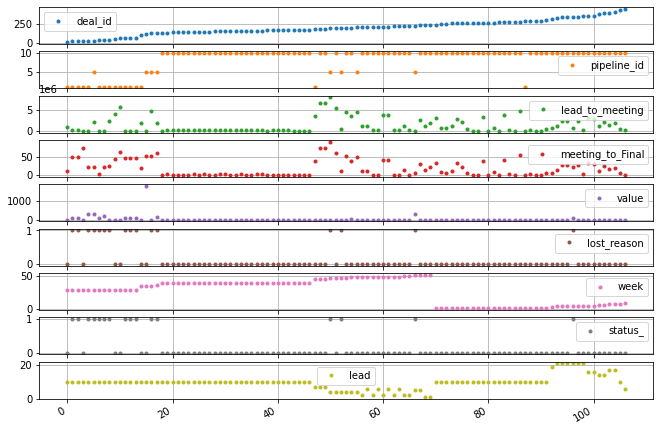

In [45]:
winrate.plot(marker='.', linestyle='None', figsize=(11,8), subplots=True, grid=True)

In [36]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# X, y = make_classification(n_samples=100, random_state=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

In [41]:
X = winrate[['meeting_to_Final', 'value', 'lead']]
y = winrate.status_
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [42]:
clf = MLPClassifier(random_state=1, max_iter=1000, hidden_layer_sizes=(100, 200), activation='tanh',
                   solver='sgd', ).fit(X_train, y_train)

In [43]:
clf.score(X_test, y_test)

1.0

In [44]:
clf.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0])

In [46]:
from sklearn.tree import DecisionTreeClassifier
tree_model = DecisionTreeClassifier()

tree_model.fit(X_train, y_train)

DecisionTreeClassifier()

In [47]:
tree_model.score(X_test,y_test)

0.8888888888888888

In [48]:
tree_model.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1])

In [62]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC

clf_svc = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel='rbf'))
clf_svc.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [64]:
clf_svc.score(X, y)

0.9439252336448598

In [66]:
from sklearn.naive_bayes import CategoricalNB

clf_nb = CategoricalNB()
clf_nb.fit(X, y)

CategoricalNB()

In [68]:
clf_nb.score(X, y)

0.9158878504672897

In [70]:
ln = LinearRegression().fit(X_train, y_train)
ln.score(X_test,y_test)

-0.006398874618823047

In [90]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=9)
neigh.fit(X,y)

KNeighborsClassifier(n_neighbors=9)

In [91]:
neigh.score(X,y)

0.9439252336448598